In [1]:
import nltk
import pandas as pd
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import nltk
import math
from collections import Counter


/Users/pauli/Library/Mobile Documents/com~apple~CloudDocs/TU/Python/Vis2/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/pauli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/pauli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/pauli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/pauli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv("./data/dblp-v10-titles_and_date-only.csv")

In [3]:
df = df.head(100000)

In [5]:
df

,title,year
0,A new approach of 3D watermarking based on ima...,2008
1,Attractor neural networks with activity-depend...,2007
2,A characterization of balanced episturmian seq...,2007
3,Exploring the space of a human action,2005
4,Generalized upper bounds on the minimum distan...,2015
...,...,...
99995,Design of a system for real-time worm detection,2004
99996,A novel optical Bi-Cell with integrated readou...,1999
99997,A genetic algorithm for generating multiple pa...,2010
99998,Ab-initio calculation of elastic constants of ...,2009


In [5]:
def token_and_filter_pos_combos(text_corpus):
    # Initialize lemmatizer and stopword set
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    corpus = []
    for sent in tqdm(text_corpus):
        sent_tokens = []
        words = []

        # Tokenize and POS tag
        for word, tag in nltk.pos_tag(nltk.word_tokenize(sent.lower())):
            # Lemmatize the word
            lemmatized_word = lemmatizer.lemmatize(word)
            
            # Check if the word is a stopword or punctuation
            if lemmatized_word not in stop_words and lemmatized_word.isalpha():
                if tag in {"JJ", "JJR", "JJS", "NN", "NNS", "NNP", "NNPS"}:
                    words.append(lemmatized_word)
                else:
                    if len(words) > 0:
                        sent_tokens.append(" ".join(words))
                    words = []

        # Append remaining words in the sentence
        if len(words) > 0:
            sent_tokens.append(" ".join(words))
        corpus.append(sent_tokens)

    return corpus


In [6]:
terms = token_and_filter_pos_combos(df['title'].to_list())

100%|██████████| 100000/100000 [00:30<00:00, 3265.29it/s]


In [7]:
terms

[['new approach', 'image segmentation'],
 ['attractor neural network synapsis role synaptic facilitation'],
 ['characterization balanced episturmian sequence'],
 ['space human action'],
 ['upper bound minimum distance psk block code'],
 ['bcmp',
  'network performance evaluation hierarchical modular software system'],
 ['cmos vco'],
 ['computability pattern recognition problem'],
 ['biological mechanical'],
 ['novel injection', 'rotary', 'wave oscillator'],
 ['abundance invariant polynomial', 'riemann hypothesis'],
 ['entity resolution iterative blocking'],
 ['accuracy java profilers'],
 ['robust architecture video transmission channel'],
 ['useful computation', 'useful number'],
 ['content aware image retargeting'],
 ['scaddar efficient randomized technique', 'continuous medium block'],
 ['importance', 'markovian setting'],
 ['identification gene cereal crop arabidopsis comparative analysis multiple est set'],
 [],
 ['impact', 'volume independent variable solution equilibrium equation

In [8]:
def compute_tf_icf(sentence_terms):
    # Flatten list of terms for TF computation
    flattened_terms = [term for sentence in sentence_terms for term in sentence]
    term_counts = Counter(flattened_terms)
    
    # Total number of terms
    total_terms = len(flattened_terms)
    
    # Compute TF for each term
    tf = {term: count / total_terms for term, count in term_counts.items()}
    
    # Compute ICF for each term
    total_sentences = len(sentence_terms)
    term_in_sentences = Counter(term for sentence in sentence_terms for term in set(sentence))
    icf = {term: math.log(total_sentences / (1 + count)) for term, count in term_in_sentences.items()}
    
    # Compute TF-ICF
    tf_icf = {term: tf[term] * icf[term] for term in tf.keys()}
    
    return tf_icf

In [9]:
tf_icf_scores = compute_tf_icf(terms)

In [ ]:
# Sort tf_icf_scores in descending order by value
sorted_tf_icf_scores = dict(sorted(tf_icf_scores.items(), key=lambda item: item[1], reverse=True))

# Take the top 500 terms
top_500_terms = list(sorted_tf_icf_scores.keys())[:500]

# Normalize their values so the total adds up to 1
# Create a new dictionary with only the top 500 terms and scaled values
top_500_tf_icf_scores = {
    term: sorted_tf_icf_scores[term] / sum(top_500_terms[term] for term in top_500_terms)
    for term in top_500_terms
}

top_500_tf_icf_scores


{'system': 0.03197452005701394,
 'approach': 0.023011949826135292,
 'algorithm': 0.018112684435183265,
 'method': 0.01639168434549538,
 'network': 0.013963624636241087,
 'data': 0.013559792305651604,
 'model': 0.013433549643344436,
 'image': 0.010165807201646762,
 'application': 0.008995301927145108,
 'framework': 0.008447820674570268,
 'neural network': 0.008044884104573703,
 'technique': 0.007790890441288565,
 'scheme': 0.007018206017219727,
 'towards': 0.006966089619361615,
 'problem': 0.00691389402752529,
 'object': 0.006651703187583876,
 'environment': 0.006546246970813882,
 'architecture': 0.006440450058671304,
 'efficient': 0.006281101485466955,
 'genetic algorithm': 0.006120948335431303,
 'design': 0.005852170866997019,
 'simulation': 0.005852170866997019,
 'video': 0.005798128218552715,
 'graph': 0.005580965438787599,
 'analysis': 0.005425995969369798,
 'wireless sensor network': 0.0049750618946010775,
 'performance': 0.004919304755831652,
 'software': 0.0048634288352470065,
 

In [14]:
# Sort tf_icf_scores in descending order by value
sorted_tf_icf_scores = dict(sorted(tf_icf_scores.items(), key=lambda item: item[1], reverse=True))

# Take the top 500 terms
top_500_terms = list(sorted_tf_icf_scores.keys())[:500]

# Compute the sum of the top 500 terms' values for normalization
top_500_sum = sum(sorted_tf_icf_scores[term] for term in top_500_terms)

# Normalize their values so the total adds up to 1 (only based on top 500 terms)
top_500_tf_icf_scores = {
    term: sorted_tf_icf_scores[term] / top_500_sum
    for term in top_500_terms
}



1.000000000000004

In [28]:
top_500_tf_icf_scores

{'system': 0.03197452005701394,
 'approach': 0.023011949826135292,
 'algorithm': 0.018112684435183265,
 'method': 0.01639168434549538,
 'network': 0.013963624636241087,
 'data': 0.013559792305651604,
 'model': 0.013433549643344436,
 'image': 0.010165807201646762,
 'application': 0.008995301927145108,
 'framework': 0.008447820674570268,
 'neural network': 0.008044884104573703,
 'technique': 0.007790890441288565,
 'scheme': 0.007018206017219727,
 'towards': 0.006966089619361615,
 'problem': 0.00691389402752529,
 'object': 0.006651703187583876,
 'environment': 0.006546246970813882,
 'architecture': 0.006440450058671304,
 'efficient': 0.006281101485466955,
 'genetic algorithm': 0.006120948335431303,
 'design': 0.005852170866997019,
 'simulation': 0.005852170866997019,
 'video': 0.005798128218552715,
 'graph': 0.005580965438787599,
 'analysis': 0.005425995969369798,
 'wireless sensor network': 0.0049750618946010775,
 'performance': 0.004919304755831652,
 'software': 0.0048634288352470065,
 

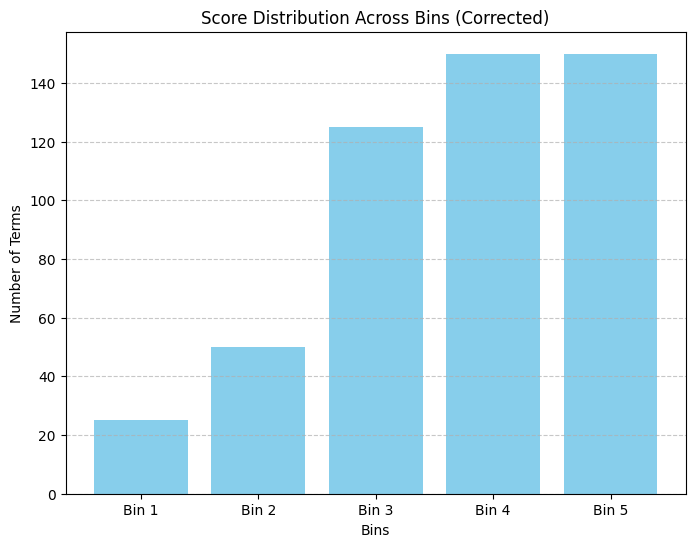

Bin 1 has 25 terms
Bin 2 has 50 terms
Bin 3 has 125 terms
Bin 4 has 150 terms
Bin 5 has 150 terms


In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Assume top_500_tf_icf_scores is a dictionary with term: normalized_score
scores = np.array(sorted(top_500_tf_icf_scores.values(), reverse=True))  # Sort scores descending

# Desired percentages for bins (must sum to 100%)
bin_percentages = [30, 30, 25, 10, 5]  # Percentages for Bins 5, 4, 3, 2, 1

# Calculate the number of terms in each bin
num_terms = len(scores)
bin_sizes = [int(num_terms * (p / 100)) for p in bin_percentages]

# Adjust bin sizes to ensure the total matches num_terms
bin_sizes[-1] += num_terms - sum(bin_sizes)  # Adjust the last bin to include any leftover terms

# Create bin cutoff indices
cutoff_indices = np.cumsum(bin_sizes)

# Assign bins based on cutoff indices (highest scores in lower group numbers)
bins = np.zeros(num_terms, dtype=int)
start_idx = 0
for bin_num, end_idx in enumerate(cutoff_indices, start=1):
    bins[start_idx:end_idx] = 6 - bin_num  # Reverse bin numbering
    start_idx = end_idx

# Count the number of terms in each bin
bin_counts = [np.sum(bins == i) for i in range(1, len(bin_percentages) + 1)]

bin_labels = [f"Bin {i}" for i in range(1, len(bin_percentages) + 1)]
plt.figure(figsize=(8, 6))
plt.bar(bin_labels, bin_counts, color='skyblue')
plt.xlabel("Bins")
plt.ylabel("Number of Terms")
plt.title("Score Distribution Across Bins (Corrected)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

for i in range(1, len(bin_percentages) + 1):
    print(f"Bin {i} has {bin_counts[i - 1]} terms")


In [70]:
from gensim.models import Word2Vec

# Assume top_500_terms is the list of terms (words or multi-word phrases)
top_500_terms = list(top_500_tf_icf_scores.keys())  # Extract top 500 terms

# Prepare data for Word2Vec
# Treat each term (single-word or multi-word phrase) as a "sentence"
sentences = [[term] for term in top_500_terms]  # Each term is a single-element list

# Train Word2Vec with improved parameters
word2vec_model = Word2Vec(
    sentences,
    vector_size=300,       # Increased vector dimensions to capture more semantic information
    window=10,             # Larger context window for more global information
    min_count=1,           # Include all terms
    sg=1,                  # Skip-Gram model 
    epochs=50,             # Train for more iterations
    workers=4              # Use multiple CPU cores for training
)

# Save the model if needed
word2vec_model.save("top_500_word2vec_sentences_improved.model")

# Example: Access the vector for a specific term
example_term = top_500_terms[0]  # Replace with any term from the top 500
if example_term in word2vec_model.wv:
    print(f"Vector for '{example_term}':\n", word2vec_model.wv[example_term])
else:
    print(f"'{example_term}' not found in the vocabulary.")

# Fine-tune the model by additional training
additional_sentences = sentences  
word2vec_model.build_vocab(additional_sentences, update=True)  # Update the vocabulary
word2vec_model.train(
    additional_sentences,
    total_examples=word2vec_model.corpus_count,
    epochs=30  # Additional training epochs
)

# Save the fine-tuned model
word2vec_model.save("top_500_word2vec_sentences_finetuned.model")


Vector for 'system':
 [-4.7090134e-04 -3.6065618e-04 -3.2096556e-03 -1.2459572e-03
 -3.7813186e-06 -1.2999495e-04 -4.5443932e-04 -2.3877018e-03
  7.6944230e-04 -5.6074100e-04  2.7947004e-03  1.3511137e-03
  2.1078109e-03 -2.0060786e-03 -4.6467702e-04  1.4426089e-03
  2.5195249e-03 -6.0489256e-04  1.8762887e-03 -3.1375540e-03
 -2.9687087e-06 -3.5467229e-04 -1.7233451e-03  5.7281973e-04
  2.2531045e-03 -9.0858224e-04 -1.1739993e-03 -1.3744625e-03
 -6.5509160e-04 -3.2537682e-03 -4.5758963e-04 -2.2304361e-03
  3.7941852e-04  1.6414078e-03  3.2704074e-03 -1.4674000e-03
 -9.3390385e-04  1.6035835e-03 -3.3023520e-03 -2.4415276e-03
 -1.3824848e-03 -6.0328684e-04 -9.4805716e-04 -1.7326688e-03
  7.3738495e-04  2.6179755e-03  1.6053546e-03  2.8990377e-03
  2.8780289e-03 -1.7276617e-03  2.5596893e-03  1.8292629e-03
 -1.3062226e-03 -1.3045482e-03 -3.0321677e-04 -1.1247635e-04
 -2.8338388e-03 -1.8389301e-03  2.2646217e-03 -2.2328512e-03
 -7.5141748e-04 -6.9442191e-05 -2.5463668e-03 -7.0080202e-04
  

/Users/pauli/Library/Mobile Documents/com~apple~CloudDocs/TU/Python/Vis2/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/pauli/Library/Mobile Documents/com~apple~CloudDocs/TU/Python/Vis2/.venv/lib/python3.9/site-packages/umap/umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/pauli/Library/Mobile Documents/com~apple~CloudDocs/TU/Python/Vis2/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


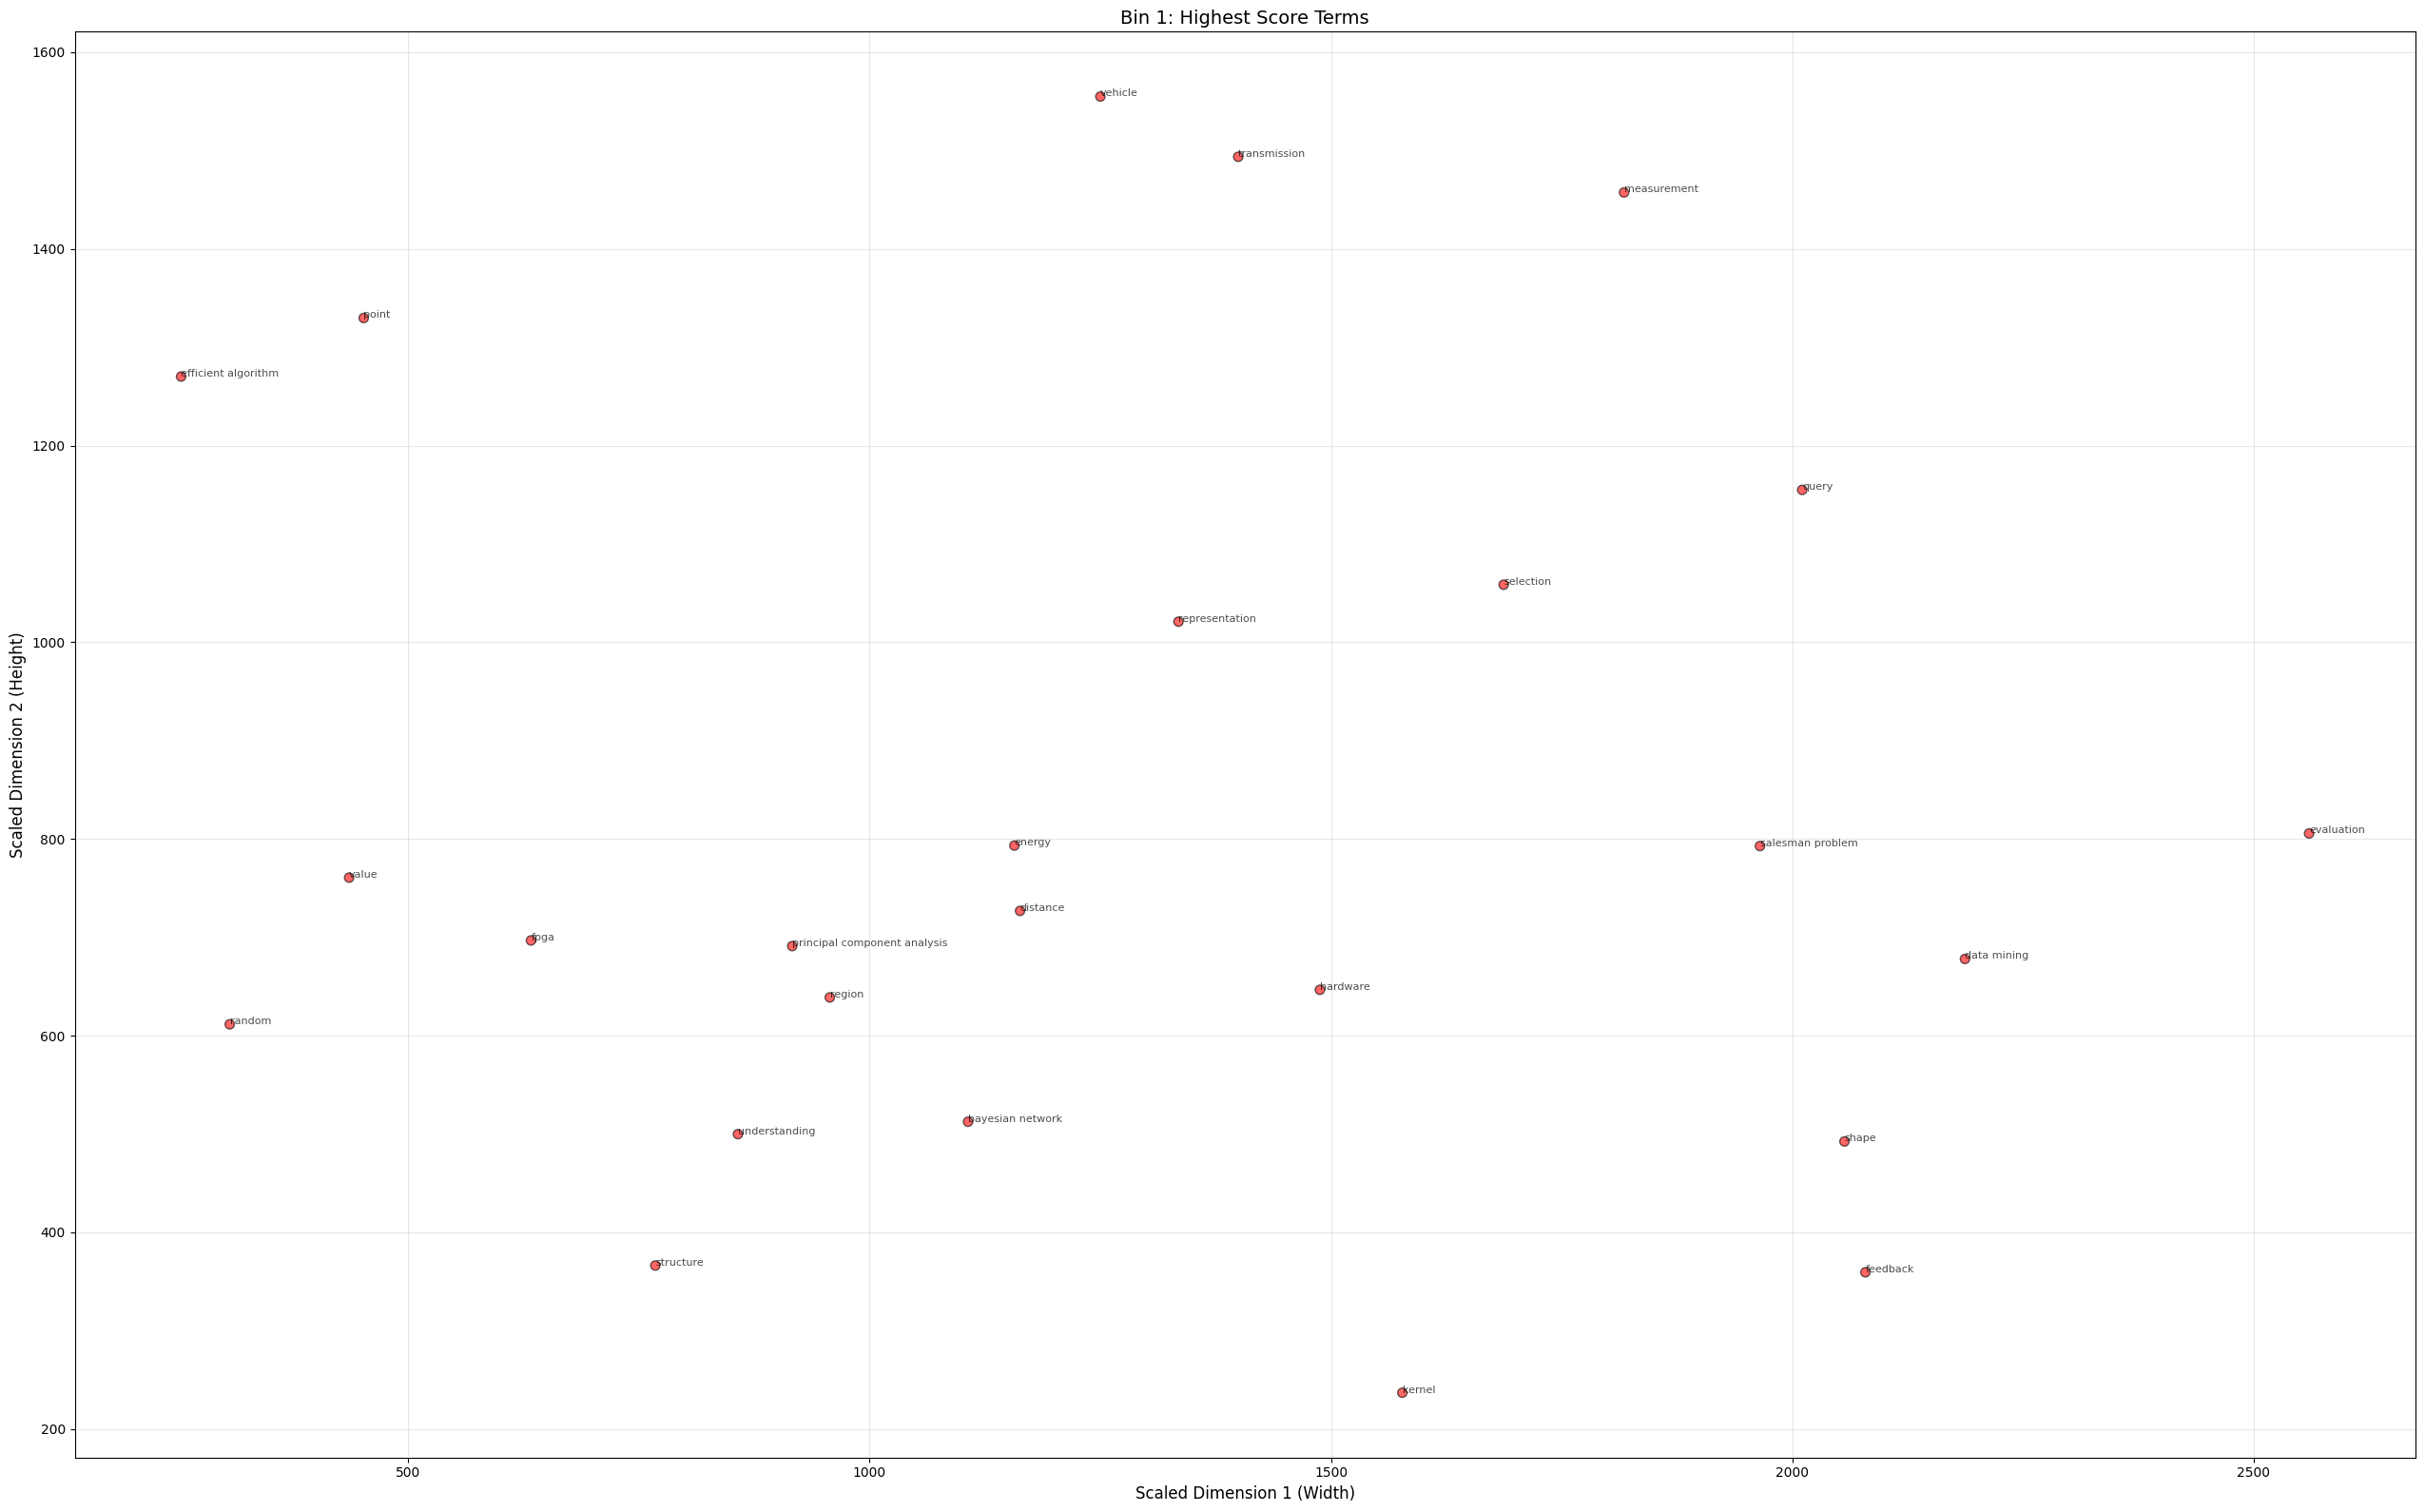

In [72]:
import umap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Combine terms and embeddings for all bins
all_terms = []  # List of all terms
all_embeddings = []  # Corresponding embeddings
all_bin_labels = []  # Bin labels for coloring

for bin_number in range(1, 6):  # Adjust for 5 bins
    bin_terms = terms_by_bin[bin_number]
    bin_embeddings = [word2vec_model.wv[term] for term in bin_terms]
    
    all_terms.extend(bin_terms)
    all_embeddings.extend(bin_embeddings)
    all_bin_labels.extend([bin_number] * len(bin_terms))

all_embeddings = np.array(all_embeddings)

# Reduce embeddings to 2D using UMAP with adjusted parameters
umap_reducer = umap.UMAP(n_components=2, random_state=42, min_dist=2, spread=18.0)
reduced_embeddings = umap_reducer.fit_transform(all_embeddings)

# Scale the coordinates to fit a 2560x1600 "screen resolution"
scaler = MinMaxScaler(feature_range=(0, 1))  # Scale to 0-1
scaled_embeddings = scaler.fit_transform(reduced_embeddings)

# Adjust to fit the screen resolution
scaled_embeddings[:, 0] *= 2560  # Scale x-coordinates to 2560 width
scaled_embeddings[:, 1] *= 1600  # Scale y-coordinates to 1600 height

# Filter data for Bin 1 only
bin1_indices = [i for i, bin_label in enumerate(all_bin_labels) if bin_label == 1]
bin1_embeddings = scaled_embeddings[bin1_indices]
bin1_terms = [all_terms[i] for i in bin1_indices]

# Color for Bin 1
bin1_colors = ["red" for _ in bin1_indices]

# Plot Bin 1 only
plt.figure(figsize=(25.6, 16))  
plt.scatter(
    bin1_embeddings[:, 0],
    bin1_embeddings[:, 1],
    c=bin1_colors,
    alpha=0.6,
    s=50,
    edgecolors='k'
)
for i, term in enumerate(bin1_terms):
    plt.text(bin1_embeddings[i, 0], bin1_embeddings[i, 1], term, fontsize=8, alpha=0.7)
plt.title("Bin 1: Highest Score Terms", fontsize=14)
plt.xlabel("Scaled Dimension 1 (Width)", fontsize=12)
plt.ylabel("Scaled Dimension 2 (Height)", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [73]:
import json
import numpy as np

# Define the bins based on score ranges (example: 5%, 10%, 15%, 30%, 40%)
bin_percentages = [5, 10, 15, 30, 40]  
sorted_terms = sorted(top_500_tf_icf_scores.items(), key=lambda x: x[1], reverse=True)  # Sort by score descending
scores = np.array([score for _, score in sorted_terms])  # Extract scores
cumulative_cutoffs = np.cumsum([int(len(scores) * p / 100) for p in bin_percentages])  # Calculate bin cutoffs

# Create bins dynamically
bins = {1: [], 2: [], 3: [], 4: [], 5: []}
bin_labels = []
for i, (term, score) in enumerate(sorted_terms):
    for bin_number, cutoff in enumerate(cumulative_cutoffs, start=1):
        if i < cutoff:
            bins[bin_number].append((term, score))
            bin_labels.append(bin_number)
            break

# Prepare data for JSON export
data = []
for i, (term, score) in enumerate(sorted_terms):
    data.append({
        "term": term,
        "x": float(scaled_embeddings[i, 0]),  # X-coordinate
        "y": float(scaled_embeddings[i, 1]),  # Y-coordinate
        "group": bin_labels[i],  # Bin number
        "score": score  # TF-ICF score
    })

# Save to JSON
output_file = "terms.json"
with open(output_file, "w") as f:
    json.dump(data, f, indent=4)

print(f"Data successfully saved to {output_file}")


Data successfully saved to terms.json
